# Explorative Data Analysis

## Imports

In [150]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import json 
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
nltk.download('vader_lexicon')
from nltk.corpus import twitter_samples
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lucaf\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Preperation

In [151]:
pos_twee = twitter_samples.strings('positive_tweets.json')
neg_twee = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

df = pd.DataFrame (pos_twee,columns=['text'])
df['Value'] = 1
df2 = pd.DataFrame (neg_twee,columns=['text'])
df2['Value'] = -1

df=df.append(df2, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True) #shuffle neg and pos tweets 
#cleansing tweet
remove_rt = lambda x: re.sub("(RT @\w+: )|(@\w+):"," ",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|(\w+:\/\/\S+)|(\n|\t|\')"," ",x)


df["text"] = df.text.map(remove_rt).map(rt)
df["text"] = df.text.str.lower()
df.text.head(10)

#removing emoji characters
def deEmojify(text):
    regrex_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'',text)

df["text"] = df.text.map(deEmojify)

data = list(df["text"])
labels = list(df["Value"])
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data)
vectors_train = vectorizer.transform(x_train)
vectors_test = vectorizer.transform(x_test)
model = MultinomialNB(alpha=.01)
model = model.fit(vectors_train, y_train)



In [152]:
#reading the json of the data
df_tweets = pd.read_json("./cryptodoge.json", lines=True)

In [153]:
#bereinigen der Tweets
remove_rt = lambda x: re.sub("(RT @\w+: )|(@\w+):"," ",x) #herausfiltern der usernamen und RT
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|[\d\.]|(\w+:\/\/\S+)|(\n|\t|\')"," ",x) #herausfiltern markierter Usernamen 
htp = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",x) #entfernen von links, sonderzeichen, punkten

df_tweets["text"] = df_tweets.text.map(remove_rt).map(rt).map(htp)
df_tweets["text"] = df_tweets.text.str.lower()
df_tweets.text.head(10)

#bereinigen des textes von den Emojis
def deEmojify(text):
    regrex_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'',text)

df_tweets["text"] = df_tweets.text.map(deEmojify)

clean_data_list = list(df_tweets["text"])

one_test = vectorizer.transform(list(clean_data_list))
prob_single=model.predict_proba(one_test)
prob_single
neg_prob=[]
pos_prob=[]
print(type(neg_prob))

for i in prob_single:
    
    neg_prob.append(i[0])
    pos_prob.append(i[1])
    data_tweetsdfg_prob"]=neg_prob
data_tweets[df_prob"]=pos_prob
data_tweets["dfiment"]= 888

for index, neg in data_tweets["negfob"].iteritems():
    
    
    if neg > 0.55 :
        data_tweets.loc[inddfsentiment"]="negative"

    elif neg < 0.45:
        data_tweets.loc[index,dftiment"]= "positive"

    else:
        data_tweets.loc[index,"sedfent"]= "neutral"

<class 'list'>


In [154]:
#extracting followers_count from user column
df_tweets["followers_count"] = 0
for index, row in df_tweets.iterrows():
  df_tweets["followers_count"][index] = df_tweets["user"][index]["followers_count"]
#extracting location from user column
df_tweets["location"] = 0
for index, row in df_tweets.iterrows():
  df_tweets["location"][index] = df_tweets["user"][index]["location"]  
#extracting verified from user column
df_tweets["verified"] = 0
for index, row in df_tweets.iterrows():
  df_tweets["verified"][index] = df_tweets["user"][index]["verified"]  
#extracting friends_count from user column
df_tweets["friends_count"] = 0
for index, row in df_tweets.iterrows():
  df_tweets["friends_count"][index] = df_tweets["user"][index]["friends_count"]    

<ipython-input-154-b3d64be6ba62>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets["followers_count"][index] = df_tweets["user"][index]["followers_count"]
<ipython-input-154-b3d64be6ba62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets["location"][index] = df_tweets["user"][index]["location"]
C:\Users\lucaf\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [155]:
#dropping unneeded columns
df_tweets = df_tweets.drop(["created_at", "id", "id_str", "source", "truncated", "in_reply_to_status_id", "in_reply_to_status_id_str", "in_reply_to_user_id_str", "in_reply_to_user_id", "in_reply_to_screen_name", "coordinates", "place", "quoted_status_id", "quoted_status_id_str", "is_quote_status", "quoted_status", "retweeted_status", "entities", "extended_entities", "favorited", "retweeted", "possibly_sensitive", "filter_level", "contributors", "geo", "user", "extended_tweet", "quoted_status_permalink", "location", "timestamp_ms", "display_text_range", "reply_count", "quote_count", "retweet_count", "favorite_count"], axis=1)

## Data Visualizations

### Proportion of sentiment

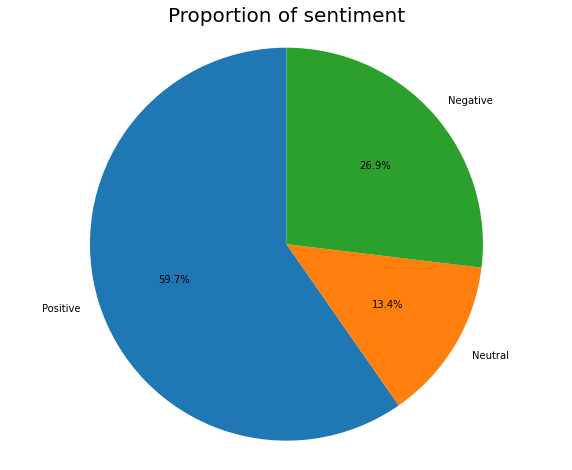

In [157]:
labels = "Positive", "Neutral", "Negative"
sizes = [df_tweets["sentiment"][df_tweets["sentiment"]=="positive"].count(), df_tweets["sentiment"][df_tweets["sentiment"]=="neutral"].count(), df_tweets["sentiment"][df_tweets["sentiment"]=="negative"].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
plt.title("Proportion of sentiment", size = 20)
plt.show()

### Categorical Information

<AxesSubplot:xlabel='verified', ylabel='count'>

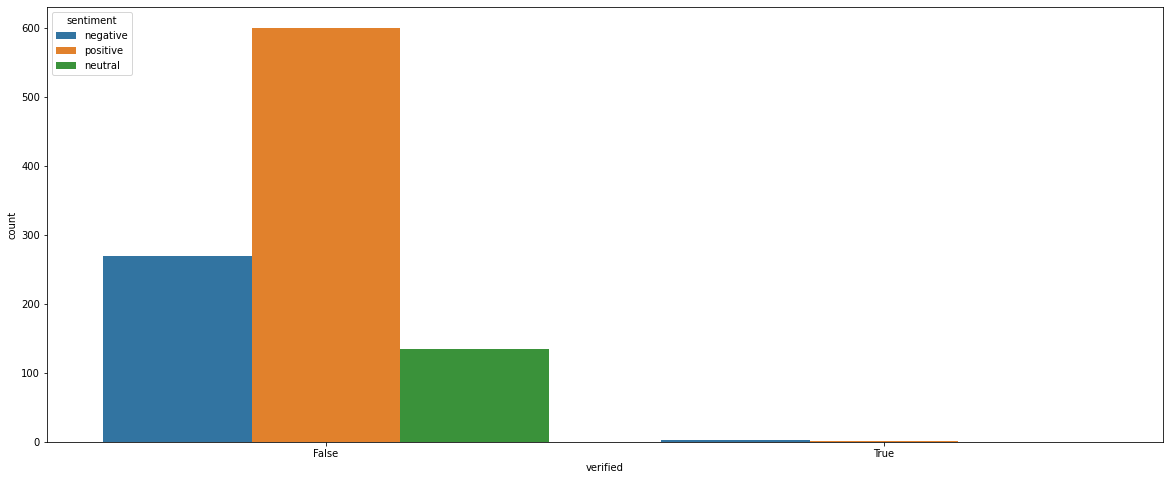

In [161]:
fig, axarr = plt.subplots(1, 1, figsize=(20, 8))
sns.countplot(x='verified', hue = 'sentiment',data = df_tweets, ax=axarr)

### Continuous Information

<AxesSubplot:xlabel='sentiment', ylabel='friends_count'>

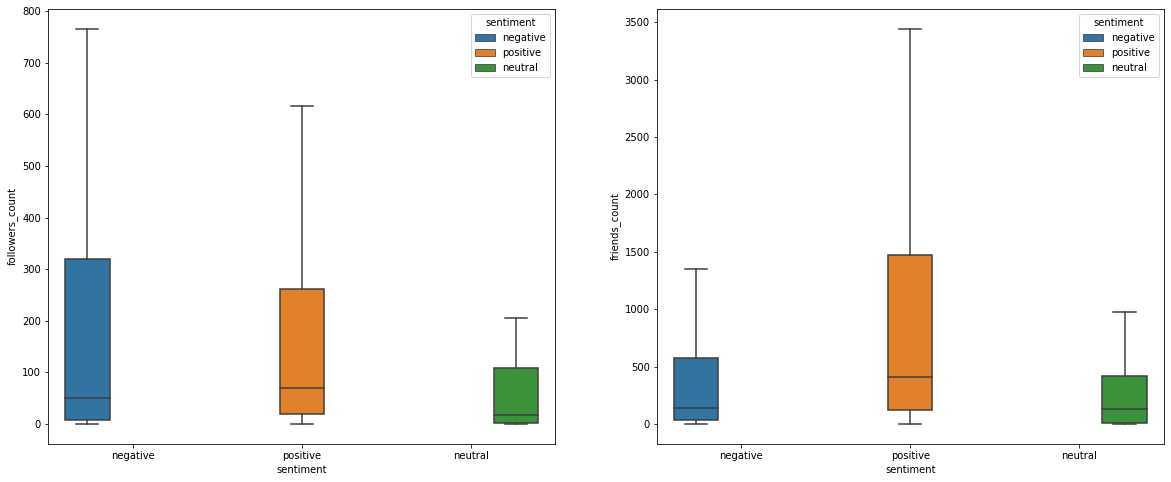

In [159]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(y='followers_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[0], showfliers=False)
sns.boxplot(y='friends_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[1], showfliers=False)

In [1]:
#